# Загружаем пакеты

In [1]:
# загрузка пакетов: инструменты --------------------------------------------
# работа с массивами
import numpy as np
# фреймы данных
import pandas as pd
# распределение Стьюдента для проверки значимости
from scipy.stats import t
# подсчёт частот внутри массива
from collections import Counter
# графики
import matplotlib as mpl
# стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets

# загрузка пакетов: модели -------------------------------------------------
# стандартизация показателей
from sklearn.preprocessing import StandardScaler
# метод главных компонент
from sklearn.decomposition import PCA
# метод частных наименьших квадратов
from sklearn.cross_decomposition import PLSRegression
# логистическая регрессия (ММП)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
# перекрёстная проверка по k блокам
from sklearn.model_selection import KFold, cross_val_score
# расчёт Acc и сводка по точности классификации
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# константы
# ядро для генератора случайных чисел
my_seed = 9212
# создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
# примеры стилей и шаблонов графиков:
# http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

In [3]:
# функция, которая строит график сжатия коэффициентов в ридж и лассо
# из репозитория к книге С.Рашки Python и машинное обучение,
# слегка переработанная
def plot_coeffs_traces (X, y, class_number, penalty_name, C_opt, col_names,
                        C_min_pow=-4, C_max_pow=3.) :
    fig = plt.figure()
    ax = plt.subplot(111)
    # палитра
    colors = sns.color_palette("Spectral", len(col_names)-1)
    
    weights, params = [], []
    for c in np.arange(C_min_pow, C_max_pow+1):
        lr = LogisticRegression(penalty=penalty_name,
                                C=10.**c, solver='liblinear',
                                multi_class='ovr', random_state=my_seed)
        lr.fit(X, y)
        weights.append(lr.coef_[class_number])
        params.append(10**c)
    weights = np.array(weights)
    for column, color in zip(range(weights.shape[1]), colors):
    
        plt.plot(params, weights[:, column],
                 label=col_names[column],
                 color=color)
    # отсечки по оптимальным C
    plt.axvline(x=C_opt[class_number], color='magenta',
                linestyle='--', linewidth=1)
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlim([10**(C_min_pow), 10**C_max_pow])
    plt.ylabel('weight coefficient')
    plt.xlabel('C')
    plt.xscale('log')
    plt.legend(loc='upper left')
    ax.legend(loc='upper center',
              bbox_to_anchor=(1.38, 1.03),
              ncol=1, fancybox=True)
    plt.show()

# Загружаем данные

In [110]:
# загружаем таблицу
url = "https://raw.githubusercontent.com/aksyuk/MTML/main/Labs/data/winequality-red_for_lab.csv"
DF = pd.read_csv(url)
# оставим в таблице только указанные переменные
DF = DF.filter(items=['fixed_acidity', 'volatile_acidity', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'pH', 'sulphates', 'alcohol', 'Y'])


Отложим 15% наблюдений для прогноза

In [111]:
# наблюдения для моделирования
DF = DF.sample(frac = 0.85, random_state = my_seed)
# отложенные наблюдения
DF_predict = DF.drop(DF.index)

In [112]:
# типы столбцов фрейма
DF.dtypes

fixed_acidity           float64
volatile_acidity        float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
pH                      float64
sulphates               float64
alcohol                 float64
Y                         int64
dtype: object

### Проверим нет ли в таблице пропусков

In [113]:
# считаем пропуски в каждом столбце
DF.isna().sum()

fixed_acidity           0
volatile_acidity        0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
pH                      0
sulphates               0
alcohol                 0
Y                       0
dtype: int64

### Пропусков не обнаружено

# Предварительный анализ данных

## Описательные статистики

Считаем доли классов целевой переменной Y.

In [114]:
# метки классов
DF.Y.unique()

array([1, 0], dtype=int64)

In [115]:
# доли классов

In [116]:
np.around(DF.Y.value_counts() / len(DF.index), 3)

1    0.532
0    0.468
Name: Y, dtype: float64

### Итак, всего целевых классов два, и их доли примерно одинаковы, с перевесом в пользу класса '1'. Все объясняющие переменные набора данных непрерывные. Рассчитаем для них описательные статистики.


In [117]:
DF.describe()

,fixed_acidity,volatile_acidity,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,pH,sulphates,alcohol,Y
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.337013,0.527792,2.554746,0.087676,15.866078,46.738779,3.308219,0.658661,10.403557,0.532009
std,1.756618,0.177531,1.450287,0.048260,10.634496,33.416700,0.153734,0.172279,1.067067,0.499158
min,4.600000,0.120000,0.900000,0.012000,1.000000,6.000000,2.740000,0.330000,8.400000,0.000000
25%,7.100000,0.392500,1.900000,0.070000,7.000000,22.000000,3.210000,0.550000,9.500000,0.000000
50%,7.900000,0.520000,2.200000,0.079000,13.000000,38.000000,3.310000,0.620000,10.100000,1.000000
75%,9.200000,0.640000,2.600000,0.090000,21.000000,63.000000,3.400000,0.730000,11.033333,1.000000
max,15.900000,1.580000,15.500000,0.611000,72.000000,289.000000,4.010000,2.000000,14.900000,1.000000


### Выводы по описательным статистикам: значения объясняющих переменных положительные, масштабы измерения отличаются. Для работы с методами снижения размерности и регуляризации понадобится стандартизация значений.

 

## Визуализация разброса переменных внутри классов

Построим коробчатые диаграммы для объясняющих переменных, чтобы сравнить средние уровни и разброс по классам.


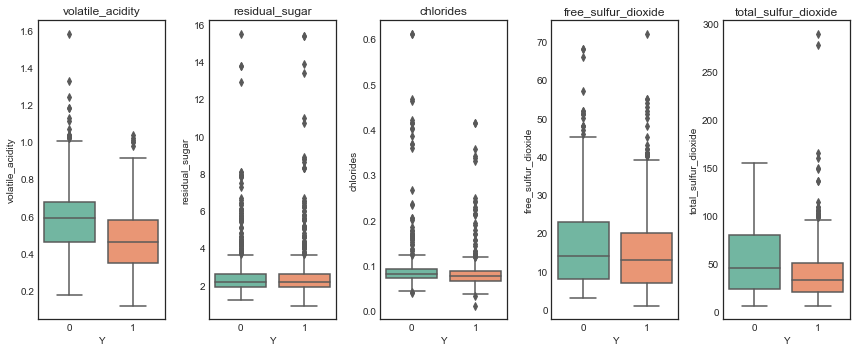

In [118]:
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[1:6].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

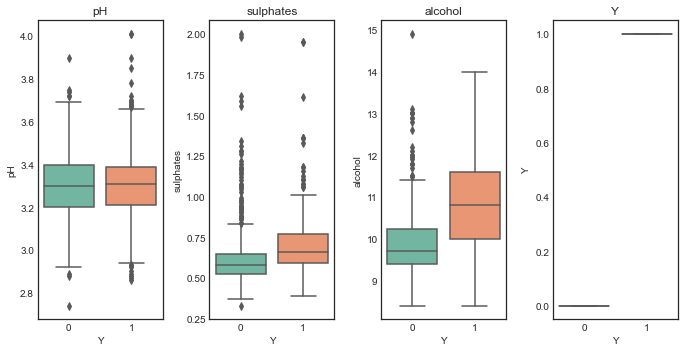

In [119]:

fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])

axs = [ax1, ax2, ax3, ax4]

cols_loop = list(DF.columns[6:10].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)
    
# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

На графиках отличие в медианах и разбросе между классами прослеживается в нескольких классах.
Больше всего различаются коробчатые диаграммы по
переменной alcohol . Это говорит о том, классы по зависимой переменной Y плохо
разделяются по всем объясняющим переменным. Также присутствует большое количество выбросов

## Корреляционный анализ

Теперь посмотрим на взаимодействие объясняющих переменных.

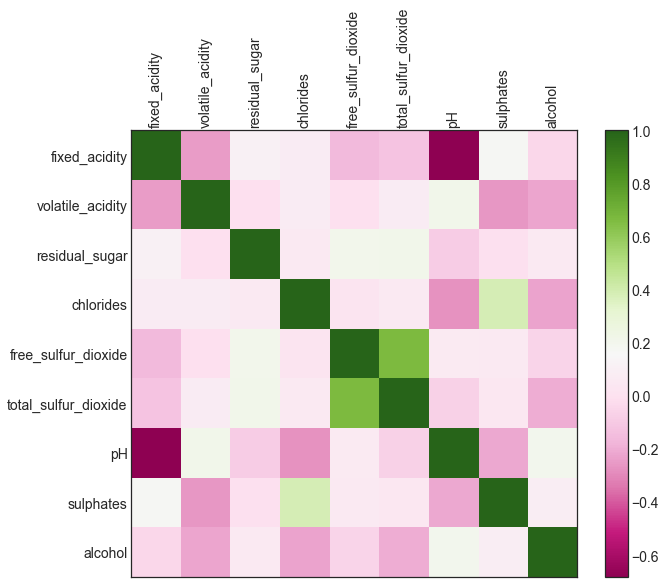

In [120]:
# рассчитываем корреляционную матрицу
corr_mat = DF.drop('Y', axis=1).corr()
col_names = DF.drop('Y', axis=1).columns
# переключаем стиль оформления, чтобы убрать сетку с тепловой карты
mpl.style.use('seaborn-white')
# рисуем корреляционную матрицу
f = plt.figure(figsize=(10, 8))
plt.matshow(corr_mat, fignum=f.number, cmap='PiYG')
# координаты для названий строк и столбцов
tics_coords = np.arange(0, len(col_names))
# рисуем подписи
plt.xticks(tics_coords, col_names, fontsize=14, rotation=90)
plt.yticks(tics_coords, col_names, fontsize=14)
# настраиваем легенду справа от тепловой карты
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(labelsize=14)
plt.show()

Между объясняющими переменными практически не обнаруживаются взаимосвязи. Выведем все значимые коэффициенты в одной таблице и определим
минимальный / максимальный из них.

In [121]:
# делаем фрейм из корреляционной матрицы и стираем диагональные значения
# и нижний треугольник матрицы
df = corr_mat
df = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
# меняем размерность с матрицы на таблицу: показатель 1, показатель 2,
# корреляция
df = df.stack().reset_index()
df.columns = ['Показатель_1', 'Показатель_2', 'Корреляция']
# считаем двусторонние p-значения для проверки значимости
t_stat = np.sqrt((len(DF.index) - 2) / (1 - df.Корреляция.values ** 2))
df['P_значение'] = 2*(1 - t.cdf(abs(t_stat), len(DF.index) - 2))
# получили все корреляционные коэффициенты без 1 и без повторов
# выводим все значимые с сортировкой
df.loc[df['P_значение'] < 0.05].sort_values('Корреляция')

,Показатель_1,Показатель_2,Корреляция,P_значение
5,fixed_acidity,pH,-0.680575,0.0
23,chlorides,pH,-0.271395,0.0
13,volatile_acidity,sulphates,-0.255494,0.0
0,fixed_acidity,volatile_acidity,-0.242167,0.0
25,chlorides,alcohol,-0.225534,0.0
14,volatile_acidity,alcohol,-0.217178,0.0
33,pH,sulphates,-0.210718,0.0
32,total_sulfur_dioxide,alcohol,-0.196372,0.0
3,fixed_acidity,free_sulfur_dioxide,-0.159035,0.0
4,fixed_acidity,total_sulfur_dioxide,-0.116626,0.0


# Методы снижения размерности

Посмотрим, как работает метод снижения размерности:
Воспользуемся методом, указанным в моем варианте, а именно - частный метод наименьших квадратов (PLS)

Оба метода требуют предварительной стандартизации переменных.

In [122]:
# стандартизация
sc = StandardScaler()
X_train_std = sc.fit_transform(DF.iloc[:, :11].values)
# проверяем средние и стандартные отклонения после стандартизации
for i_col in range(X_train_std.shape[1]) :
    print('Столбец ', i_col, ': среднее = ',
          np.round(np.mean(X_train_std[:, i_col]), 2),
          ' Станд. отклонение = ',
          np.round(np.std(X_train_std[:, i_col]), 2), sep='')

Столбец 0: среднее = -0.0 Станд. отклонение = 1.0
Столбец 1: среднее = -0.0 Станд. отклонение = 1.0
Столбец 2: среднее = -0.0 Станд. отклонение = 1.0
Столбец 3: среднее = 0.0 Станд. отклонение = 1.0
Столбец 4: среднее = 0.0 Станд. отклонение = 1.0
Столбец 5: среднее = 0.0 Станд. отклонение = 1.0
Столбец 6: среднее = -0.0 Станд. отклонение = 1.0
Столбец 7: среднее = -0.0 Станд. отклонение = 1.0
Столбец 8: среднее = -0.0 Станд. отклонение = 1.0
Столбец 9: среднее = -0.0 Станд. отклонение = 1.0


## Метод частных наименьших квадратов

Сначала посмотрим, как работает метод на всех наблюдениях обучающего набора.

In [123]:

# функция для оценки модели, берём все компоненты, по числу столбцов X
pls = PLSRegression(n_components=9)
# значения зависимой переменной превращаем в фиктивные по классам
Y_train = pd.get_dummies(DF[['Y']].astype(str))
# оцениваем
pls.fit(X_train_std, Y_train)

# считаем долю объяснённой дисперсии
frac_var_expl = np.var(pls.x_scores_, axis = 0) / np.sum(np.var(X_train_std, axis = 0))
print('Доли объяснённой дисперсии по компонентам в PLS:\n',
     np.around(frac_var_expl, 3),
     '\nОбщая сумма долей:', np.around(sum(frac_var_expl), 3))

Доли объяснённой дисперсии по компонентам в PLS:
 [0.173 0.085 0.129 0.126 0.076 0.072 0.056 0.054 0.049] 
Общая сумма долей: 0.819


Из-за того, что при вычислении компонент метдом PLS мы учитываем корреляцию с ,
компоненты, во-первых, не ортогональны, а во-вторых сумма объяснённых долей дисперсии
уже не равняется 1.

In [125]:
# сокращаем пространство компонент до 2
pls = PLSRegression(n_components=2)
# перестраиваем модель
pls.fit(X_train_std, Y_train)
# пересчитываем X
X_train_pls = pls.transform(X_train_std)
# предсказываем принадлежности классов для обучающего набора
Y_train_pred = pls.predict(X_train_std)
pd.DataFrame(Y_train_pred)

,0,1
0,0.145418,0.854582
1,1.052510,-0.052510
2,1.064220,-0.064220
3,-0.149691,1.149691
4,-0.023901,1.023901
...,...,...
1354,0.954871,0.045129
1355,0.033425,0.966575
1356,0.914239,0.085761
1357,-0.013626,1.013626


In [126]:
# вычисляем классы
Y_train_hat = list()
for y_i in Y_train_pred :
    Y_train_hat.append([i for i in range(len(y_i)) if y_i[i] == max(y_i)][0])
    
# сколько наблюдений попали в каждый класс по модели
Counter(Y_train_hat).items()

dict_items([(1, 723), (0, 636)])

Рисуем классы на графике в координатах 2 главных компонент по PLS.

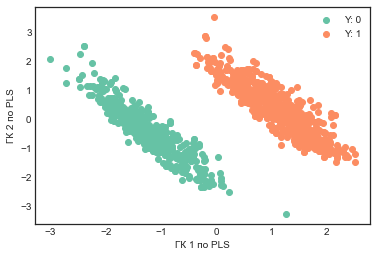

In [127]:
# график классов в пространстве ГК
plt.scatter(X_train_pls[DF['Y'] == 0][:, 0],
            X_train_pls[DF['Y'] == 0][:, 1], label='Y: 0')
plt.scatter(X_train_pls[DF['Y'] == 1][:, 0],
            X_train_pls[DF['Y'] == 1][:, 1], label='Y: 1')
plt.xlabel('ГК 1 по PLS')
plt.ylabel('ГК 2 по PLS')
plt.legend()
plt.show()

Видно, что в координатах двух компонент, рассчитанных методом частных наименьших
квадратов, классы также оказываются хорошо разделимы.
Теперь оценим точность модели с перекрёстной проверкой.

In [137]:
score=[]
score_models = []
# функция разбиения на блоки для перекрёстной проверки
# для чистоты эксперимента возьмём другое ядро генератора случайных чисел
kf_10 = KFold(n_splits=10, random_state=my_seed+1, shuffle=True)
# считаем точность модели (Acc) с перекрёстной проверкой по блокам
# функция cross_val_score не сработает, т.к. у нас мультиклассовая
# классификация, поэтому делаем вручную
# значения Y как метки классов
Y_train = DF.Y.values
# значения Y как фиктивные переменные
Y_train_dummy = pd.get_dummies(Y_train.astype(str))
# модель внутри блока
pls_cv = PLSRegression(n_components=2)
# для записи Acc по блокам
acc_blocks = list()
# цикл по блокам
for train_index, test_index in kf_10.split(X_train_std, DF.Y.values) :
    # данные для модели внутри блока
    X_i_train = X_train_std[train_index]
    Y_i_train = Y_train_dummy.iloc[train_index, :]
    # данные для прогноза вне блока
    X_i_test = X_train_std[test_index]
    Y_i_test = Y_train[test_index]
    # оцениваем модель на блоке
    pls_cv.fit(X_i_train, Y_i_train)
    # делаем прогноз y вне блока
    Y_pred = pls.predict(X_i_test)
    Y_hat = list()
    for y_i in Y_pred :
        Y_hat.append([i for i in range(len(y_i)) if y_i[i] == max(y_i)][0])
        # считаем точность
    acc = accuracy_score(Y_i_test, Y_hat)
    acc_blocks.append(acc)
        
score.append(np.around(np.mean(acc_blocks), 2))
score_models.append('logit_PLS')
print('Модель ', score_models[0], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', np.around(score[0], 2), sep='')

Модель logit_PLS, перекрёстная проверка по 10 блокам
Acc = 1.0


# Методы сжатия

## Лассо-регрессия

Технически реализация лассо-регрессии отличается от ридж единственным аргументом
penalty='l1' в функции LogisticRegression .

In [138]:
# функция для построения модели
logit_lasso = LogisticRegression(penalty='l2', solver='liblinear')
# оцениваем параметры
logit_lasso.fit(X_train_std, Y_train)
# выводим параметры
print('Константы моделей для классов:\n', np.around(logit_lasso.intercept_, 3),
      '\nКоэффициенты моделей для классов:\n', np.around(logit_lasso.coef_, 3))

Константы моделей для классов:
 [0.372] 
Коэффициенты моделей для классов:
 [[ 0.024 -0.212  0.006 -0.096  0.056 -0.219 -0.011  0.185  0.349  5.337]]


Отметим, что в векторе коэффициентов появились нулевые значения: метод лассо позволяет
обнулять коэффициенты, тем самым отбрасывая слабые объясняющие переменные.

In [139]:
# поиск оптимального значения C:
# подбираем C по наибольшей точности с перекрёстной проверкой
lasso_cv = LogisticRegressionCV(cv=10, random_state=my_seed,
                                penalty='l1', solver='liblinear')
lasso_cv.fit(X_train_std, Y_train)
# значения параметра C (инверсия лямбды), которые дают наилучшую
# точность для каждого класса
lasso_cv.C_

array([0.00599484])

In [140]:
# сохраняем и выводим Acc для модели
score.append(np.around(lasso_cv.score(X_train_std, Y_train), 3))

In [141]:
score_models.append('logit_lasso')
print('Модель ', score_models[1], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', score[1], sep='')

Модель logit_lasso, перекрёстная проверка по 10 блокам
Acc = 1.0


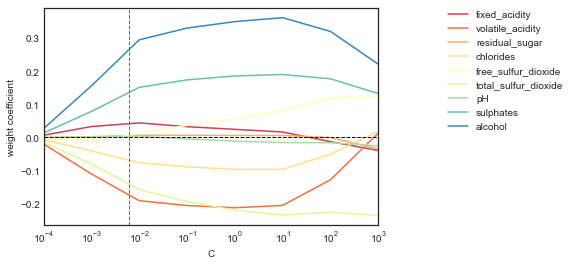

In [149]:
# график динамики коэффициентов в лассо-регрессии
# модель для класса 0
plot_coeffs_traces(X_train_std, Y_train, 0, 'l2', lasso_cv.C_, DF.columns)

Итак, судя по графикам, для значения гиперпараметра, дающего самую точную модель, ни
один коэффициент при объясняющих переменных не обнуляется. Это подтверждает
наблюдение, сделанное нами ещё на этапе предварительного анализа: все объясняющие
переменные неплохо разделяют классы.

# Прогноз на отложенные наблюдения по лучшей модели

In [150]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,logit_PLS,1.0
1,logit_lasso,1.0


Все модели показывают высокую точность по показателю. Сделаем прогноз на отложенные наблюдения.
